### Step 0: Initializing Torch and Verifying GPU

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device

0
1
NVIDIA GeForce GTX 1650 Ti


device(type='cuda', index=0)

## Optimization algorithms for linear regression

### Task 1: Stochastic Gradient Descent

In [93]:
import seaborn as sns
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import itertools
torch.set_default_dtype(torch.float32)
%matplotlib inline

Dataset Generator Function:  
$\sin(2 \pi x) + ϵ$ ; where ϵ is $N(\mu=0.0, \sigma^2=0.3)$

The ideal target hypothesis would be:  
$\sin(2 \pi x)$

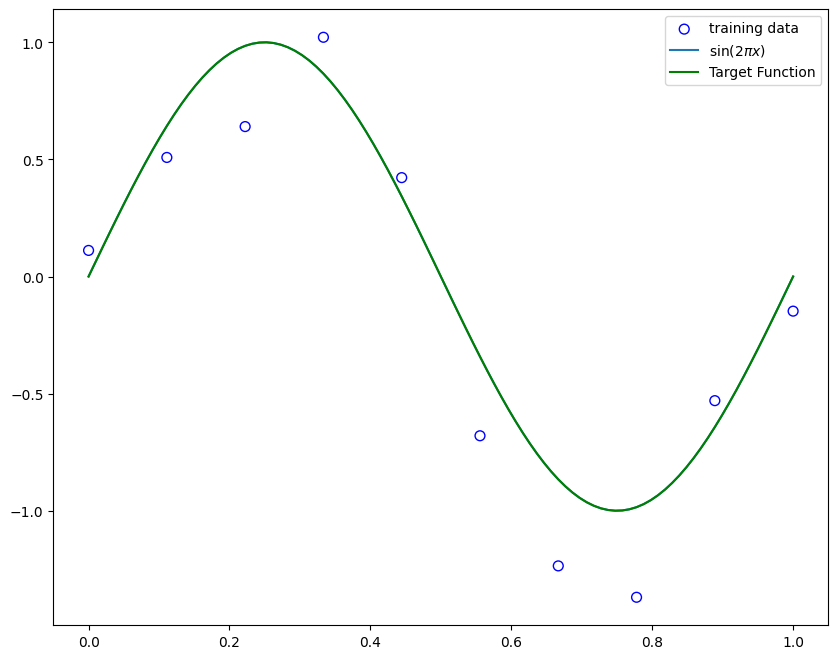

In [94]:
#Generate synthetic dataset

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

#Plot dataset and ideal target function
plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y_test, "-g", label="Target Function")
plt.legend()
plt.show()

Convert the data into tensors

In [95]:
x_train, x_test = torch.tensor(np.expand_dims(x_train, 1)), torch.tensor(np.expand_dims(x_test, 1))
y_train = torch.tensor(y_train)

Define the polynomial feature class which will generate polynomial features upto degree M for a given input

In [96]:
class PolynomialFeature:
    def __init__(self, degree):
        self.degree = degree

    def transform(self, x):
        n_samples, n_features = x.shape
        poly_x = [torch.ones(n_samples, 1)]

        for deg in range(1, self.degree + 1):
            for powers in itertools.combinations_with_replacement(range(n_features), deg):
                term = torch.ones(n_samples, 1)
                for feature_index in powers:
                    term *= x[:, feature_index].view(-1, 1)
                poly_x.append(term)

        return torch.cat(poly_x, dim=1)

Vizualization of the polynomial transform function for M = 5 representing degrees from 0 to 8

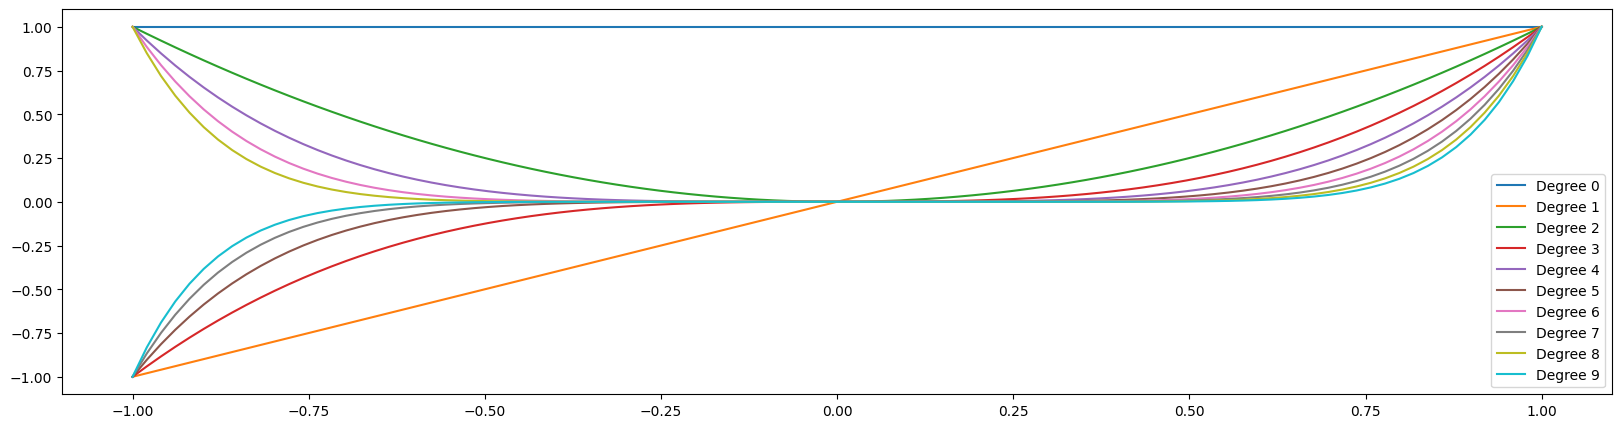

In [97]:
x = torch.linspace(-1, 1, 100).view(-1, 1)
X_polynomial = PolynomialFeature(9).transform(x)
plt.figure(figsize=(20, 5))
for j in range(10):
    plt.plot(x, X_polynomial[:, j], label=f"Degree {j}")
_ = plt.legend()

I will continue to use M=9 for the rest of the code

In [98]:
feature = PolynomialFeature(5)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

Given the data, the hypothesis function is:  
$g(\mathbf{w},\mathbf{x}) = w_0 + \sum_{j=1}^{M-1}w_j \phi_j(\mathbf x) = \mathbf w^T \mathbf \phi(\mathbf x)$  

where,  
$\phi_j$ is the basis function (In this case the PolynomialFeature function transform)  
$w$ is the bias  
$w_j$ are the weights  
x is the input

In [99]:
def hypothesis_prediction(x, weights, bias):
    y_pred = torch.matmul(x, weights) + bias
    return y_pred

For computing the error, I will be using the mean squared loss function with L2 regularization defined below:  

$L(\mathbf{w}) = \frac{1}{m} \sum_{i=1}^m \{(g(\mathbf{w},x_i)-y_i)\}^2 + \lambda \|W\|^2$

In [134]:
def compute_loss(y_pred, y_train, lambda_reg, W):
    mse_loss = (y_pred - y_train).pow(2).mean()
    l2_loss = lambda_reg * W.pow(2).sum()
    loss = mse_loss + l2_loss
    return loss

Stochastic Gradient Descent Algorithm:  


For the given loss, the gradient with respect to $w$ is:  

$ \frac{\partial \mathcal{L}}{\partial w} = \frac{-2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) \cdot (x_i) + 2 \lambda W$  

For the given loss, the gradient with respect to $b$ is:  

$\frac{\partial \mathcal{L}}{\partial b} = \frac{-2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) $  


Now that the gradients are computed, the SGD update step is:  

$w \leftarrow w - \eta \cdot \frac{\partial \mathcal{L}}{\partial w} $  

$b \leftarrow b - \eta \cdot \frac{\partial \mathcal{L}}{\partial b}$  

where,  
$L$ is loss function  
$\eta$ is learning rate  
$n$ = batch size = 1

In [139]:
def perform_SGD(y_pred, y_train, x_i, lambda_reg, W, b, learning_rate):
    grad_y_pred = 2.0  * (y_pred - y_train)

    grad_W = x_i.t() @ grad_y_pred.to(torch.float32) + 2 * lambda_reg * W
    grad_b = grad_y_pred.sum()

    # Update weights and bias using Stochastic Gradient Descent
    W -= learning_rate * grad_W
    b -= learning_rate * grad_b

    return W, b

Initialize the hyperparameters

In [219]:
learning_rate = 0.01
n_epochs = 100
lambda_reg = 0.1

Initialize the parameters

In [220]:
n_samples, n_features = X_train.shape
W = torch.randn(n_features, )
b = torch.randn(1, requires_grad=False)

Train the model using the above parameters, hypothesis function, and the stochastic gradient descent function

In [221]:
loss_values = []

for epoch in range(n_epochs):
    for i in range(n_samples):
        # Forward pass: compute predicted y
        x_i = X_train[i].unsqueeze(0)  # Shape: (1, n_features)
        y_i = y_train[i].unsqueeze(0)

        y_pred = hypothesis_prediction(x_i, W, b)

        W, b = perform_SGD(y_pred, y_i, x_i, lambda_reg, W, b, learning_rate)

    loss = compute_loss(y_pred, y_i, lambda_reg, W)
    loss_values.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.7467995988995537
Epoch 10, Loss: 0.990679771449986
Epoch 20, Loss: 0.6970482115593233
Epoch 30, Loss: 0.5597750670495292
Epoch 40, Loss: 0.48373211042063274
Epoch 50, Loss: 0.43692032445426854
Epoch 60, Loss: 0.4060728539625734
Epoch 70, Loss: 0.3847851544069138
Epoch 80, Loss: 0.36959237029777275
Epoch 90, Loss: 0.35845459261890783


Vizualize the initial hypothesis function after training

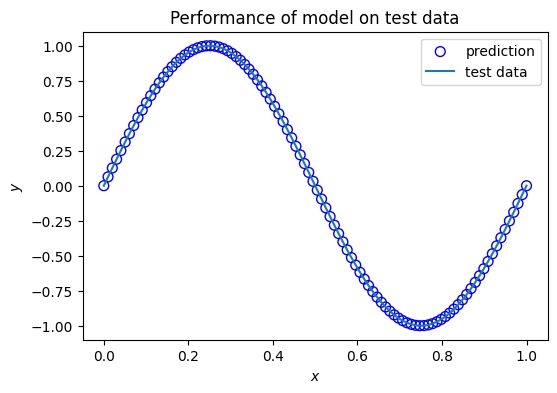

In [243]:
y_pred = hypothesis_prediction(X_test, W, b)

plt.figure(figsize=[6,4])
plt.scatter(x_test, y_test, facecolor="none", edgecolor="b", s=50, label="prediction")
plt.plot(x_test, y_test, label="test data")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Performance of model on test data")

plt.show()

Vizualize the loss vs epoch curve:

/tmp/ipykernel_35707/3556052016.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


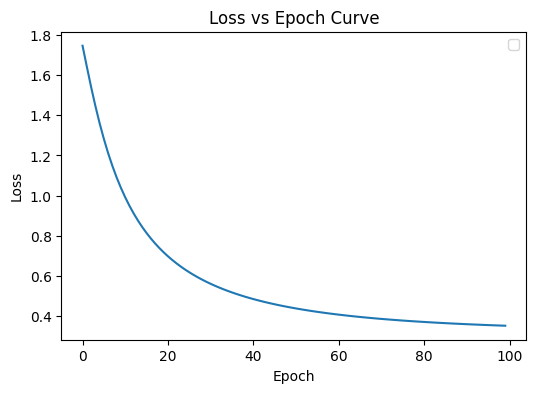

In [242]:
plt.figure(figsize=[6,4])
plt.plot(range(len(loss_values)), loss_values)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch Curve")

plt.show()

From M=9, the regularization is causing the model to work similar to $M_{eff} = 3$ as seen in the class dataset code

### Task 2: Momentum

For momentum, the velocity is computed using this equation:  

$\mathbf{v}_t \leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$  

where,  
$\mathbf{v}_t$ is the velocity at time t  
$\beta$ is the momentum  
$\mathbf{g}_{t, t-1}$ are the computed gradients

In [199]:
def perform_SGD_with_momentum(y_pred, y_train, x_i, lambda_reg, W, b, learning_rate, momentum, velocity_W, velocity_b):
    grad_y_pred = 2.0  * (y_pred - y_train)

    grad_W = x_i.t() @ grad_y_pred.to(torch.float32) + 2 * lambda_reg * W
    grad_b = grad_y_pred.sum()

    # Update weights and bias using Stochastic Gradient Descent
    W -= learning_rate * grad_W
    b -= learning_rate * grad_b

    velocity_W = momentum * velocity_W - learning_rate * grad_W
    velocity_b = momentum * velocity_b - learning_rate * grad_b

    W += velocity_W
    b += velocity_b

    return W, b

Initialize the hyperparameters

In [249]:
learning_rate = 0.01
n_epochs = 100
lambda_reg = 0.1
momentum = 0.9

Initialize the parameters

In [250]:
n_samples, n_features = X_train.shape
W = torch.randn(n_features, )
b = torch.randn(1, requires_grad=False, dtype=torch.float32)

# Initialize velocities for W and b
velocity_W = torch.zeros_like(W)
velocity_b = torch.zeros_like(b)

Train the model using the updated momentum algorithm

In [251]:
loss_values_momentum = []

for epoch in range(n_epochs):
    for i in range(n_samples):
        # Forward pass: compute predicted y
        x_i = X_train[i].unsqueeze(0)  # Shape: (1, n_features)
        y_i = y_train[i].unsqueeze(0)

        y_pred = hypothesis_prediction(x_i, W, b)

        W, b = perform_SGD_with_momentum(y_pred, y_i, x_i, lambda_reg, W, b, learning_rate, momentum, velocity_W, velocity_b)

    loss = compute_loss(y_pred, y_i, lambda_reg, W)
    loss_values_momentum.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.9832866892982726
Epoch 10, Loss: 0.6915290230492266
Epoch 20, Loss: 0.5438326884231767
Epoch 30, Loss: 0.4853605522339761
Epoch 40, Loss: 0.4508602276441236
Epoch 50, Loss: 0.42736932094252056
Epoch 60, Loss: 0.41046143147101205
Epoch 70, Loss: 0.3979383170299525
Epoch 80, Loss: 0.3884903186356013
Epoch 90, Loss: 0.38126533230309617


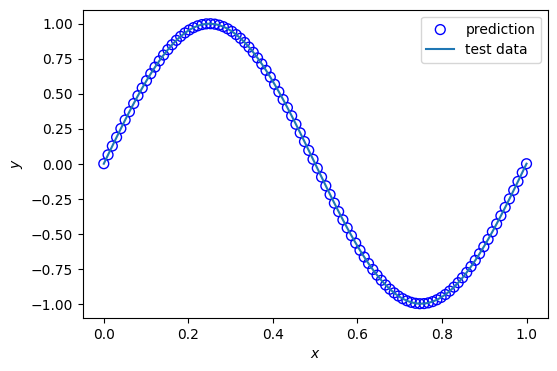

In [252]:
y_pred = hypothesis_prediction(X_test, W, b)

plt.figure(figsize=[6,4])
plt.scatter(x_test, y_test, facecolor="none", edgecolor="b", s=50, label="prediction")
plt.plot(x_test, y_test, label="test data")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")

plt.show()

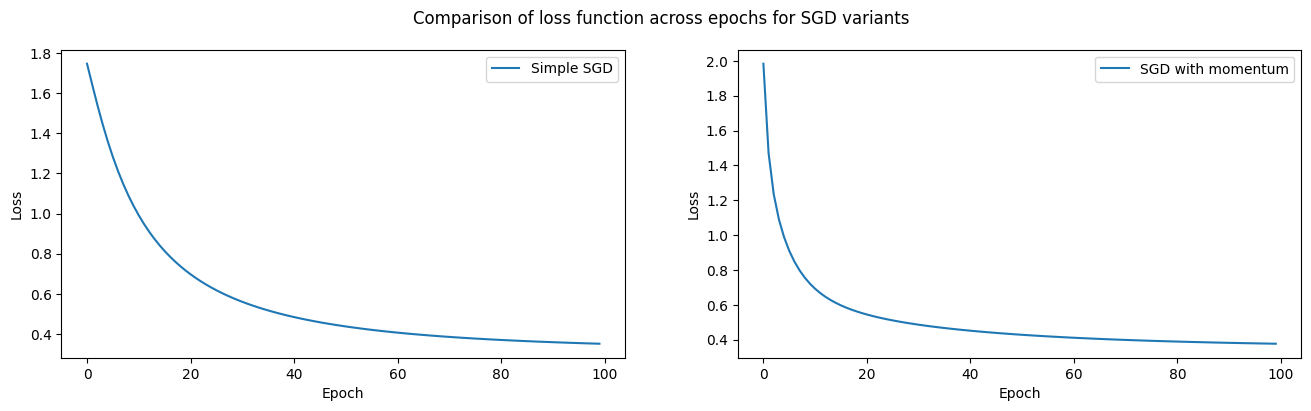

In [253]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(range(len(loss_values)), loss_values, label="Simple SGD")
ax2.plot(range(len(loss_values_momentum)), loss_values_momentum, label="SGD with momentum")
ax1.legend()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.legend()
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.suptitle("Comparison of loss function across epochs for SGD variants")

plt.show()

From the above comparison, it is clear that SGD with momentum converges much faster than simple SGD

## Logistic Regression

### Task 1: Data Preprocessing

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

The below tasks involve the following:  
1. Randomly sample 60,000 rows from the training file data
2. Read only the relevant columns
3. Divide the training data into test and training
4. Ensure that a 20% class ratio is met in test dataset
5. Ensure that a 50% class ratio us met in train dataset

In [304]:
# Specify the columns to read
use_cols = ["site_domain", "site_id", "app_category", "app_domain", "site_category",
            "C16", "C17", "C18", "C19", "C21", "app_id", "device_type", "banner_pos",
            "device_model", "device_conn_type", "device_id", "click"]

def read_data(f_name, use_cols, total_pos, total_neg):
    ones_list = []
    zeros_list = []
    ones_needed = total_pos
    zeros_needed = total_neg
    chunk_size = 100000

    # Read the data in chunks
    for chunk in pd.read_csv(f_name, usecols=use_cols, chunksize=chunk_size):
        ones_chunk = chunk[chunk.click == 1]
        zeros_chunk = chunk[chunk.click == 0]

        # Collect positive samples
        if ones_needed > 0 and not ones_chunk.empty:
            num_ones_to_take = min(len(ones_chunk), ones_needed)
            ones_list.append(ones_chunk.iloc[:num_ones_to_take])
            ones_needed -= num_ones_to_take

        # Collect negative samples
        if zeros_needed > 0 and not zeros_chunk.empty:
            num_zeros_to_take = min(len(zeros_chunk), zeros_needed)
            zeros_list.append(zeros_chunk.iloc[:num_zeros_to_take])
            zeros_needed -= num_zeros_to_take

        if ones_needed <= 0 and zeros_needed <= 0:
            break

    # Combine the collected samples
    ones_df = pd.concat(ones_list)
    zeros_df = pd.concat(zeros_list)
    df = pd.concat([ones_df, zeros_df]).sample(frac=1, random_state=42).reset_index(drop=True)

    return df

def initialize_data():
    filename = 'dataset/train'

    # Required samples for test and training sets
    test_positive = 2000
    test_negative = 8000
    train_positive = 25000
    train_negative = 25000

    total_positive = test_positive + train_positive
    total_negative = test_negative + train_negative

    # Read the required data
    df = read_data(filename, use_cols, total_positive, total_negative)

    # Separate positive and negative samples
    df_one = df[df.click == 1]
    df_zero = df[df.click == 0]

    # Create the test set with 20% positive class ratio
    test_one = df_one.sample(n=test_positive, random_state=42)
    test_zero = df_zero.sample(n=test_negative, random_state=42)
    test_df = pd.concat([test_one, test_zero]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Remove test samples from the pool to ensure DISJOINT condition specified by the TA
    df_one_remaining = df_one.drop(test_one.index)
    df_zero_remaining = df_zero.drop(test_zero.index)

    # Create the training set with 50% positive class ratio
    train_one = df_one_remaining.sample(n=train_positive, random_state=42)
    train_zero = df_zero_remaining.sample(n=train_negative, random_state=42)
    train_df = pd.concat([train_one, train_zero]).sample(frac=1, random_state=42).reset_index(drop=True)

    return train_df, test_df

# Initialize the data
train_df, test_df = initialize_data()

# Output the class distributions to verify correctness
print("Training Data:")
print(train_df.head())
print("Class distribution in training data:")
print(train_df['click'].value_counts())

print("\nTesting Data:")
print(test_df.head())
print("Class distribution in test data:")
print(test_df['click'].value_counts())

Training Data:
   click  banner_pos   site_id site_domain site_category    app_id app_domain  \
0      0           0  85f751fd    c4e18dd6      50e219e0  e2fcccd2   5c5a694b   
1      1           0  84c7ba46    c4e18dd6      50e219e0  ecad2386   7801e8d9   
2      1           0  1fbe01fe    f3845767      28905ebd  ecad2386   7801e8d9   
3      1           0  1fbe01fe    f3845767      28905ebd  ecad2386   7801e8d9   
4      0           0  030440fe    08ba7db9      76b2941d  ecad2386   7801e8d9   

  app_category device_id device_model  device_type  device_conn_type  C16  \
0     0f2161f8  a99f214a     7abbbd5c            1                 0   50   
1     07d7df22  1451a316     cf19f7f7            0                 0   50   
2     07d7df22  a99f214a     f39b265e            1                 0   50   
3     07d7df22  a99f214a     1aa0e912            1                 0   50   
4     07d7df22  a99f214a     613a3016            1                 0   50   

    C17  C18  C19  C21  
0   423   

The below tasks perform the following:  
1. Use labelencoder to perform categorical encoding on non-numerical columns
2. Normalize all the around mean and std of train data

In [305]:
#Encode the categorical columns
categorical_cols = ["site_id", "site_domain", "site_category", "app_id", "app_domain", "app_category", "device_id", "device_model"]
for cat in categorical_cols:
    train_df[cat] = train_df[cat].astype('category').cat.codes
    test_df[cat] = test_df[cat].astype('category').cat.codes


In [306]:
X_train = train_df.drop("click", axis=1)
y_train = train_df["click"]

X_test = test_df.drop("click", axis=1)
y_test = test_df["click"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

### Task 2: Implementing Logistic Regression

For Logistic regression, the binary cross entropy function is the loss function.  
It is defined as:  

$L(\mathbf{w})  = - \big[ \sum_{i=1}^m \{y_i \ln \hat{y}_i + (1-y_i) \ln (1-\hat{y}_i) \} \big]$  

Using L2 Regularization, the loss becomes:  

$L(\mathbf{w}) = - \big[ \sum_{i=1}^m \{y_i \ln \hat{y}_i + (1-y_i) \ln (1-\hat{y}_i) \} \big] + \frac{\lambda}{2} \sum_{j=1}^{n} W_j^2$

In [307]:
def binary_cross_entropy_with_l2(y_batch, y_pred, W, X, lambda_reg):
    loss = - (y_batch * torch.log(y_pred + 1e-8) + (1 - y_batch) * torch.log(1 - y_pred + 1e-8)).mean()
    loss += (lambda_reg / 2) * torch.sum(W ** 2) / X.size(0)
    return loss


For the output activation, I have used the sigmoid activation function:  

$a_i = \sigma(z_i) = \frac{1}{1 + e^{-z_i}}$  

where $z_i$ is the output from a hidden layer

In [308]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

The equations for forward and backward pass (Stochastic Gradient Descent) are described below:  

1. Forward pass before each activation:  

$z = X⋅W+b$  

2. Calculation of gradients:  

i. With Respect to the weights:  

$\nabla_W \mathcal{L} = \frac{1}{m} X^T (\hat{y} - y) + \frac{\lambda}{m} W$  

ii. With respect to the Bias:  

$\nabla_b \mathcal{L} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)$  

where:  
- $ X^T $ is the transpose of the input matrix.
- $ \hat{y} - y $ is the error vector (predicted - true values).
- $ \lambda $ is the regularization strength.

3. Stochastic gradient descent update steps:  

$W = W - \eta \nabla_W \mathcal{L}$  
$b = b - \eta \nabla_b \mathcal{L}$  

where:  
$ \eta $ is the learning rate.

In [315]:
def perform_SGD_update(y_pred, y_batch, x_batch, lambda_reg, W, X, b):
    error = y_pred - y_batch
    grad_W = x_batch.t().matmul(error) / x_batch.size(0) + (lambda_reg * W) / X.size(0)
    grad_b = error.mean()

    W -= learning_rate * grad_W
    b -= learning_rate * grad_b

    return W, b

The model parameters and hyperparameters are defined below:

In [339]:
learning_rate = 0.0001
num_epochs = 10
batch_size = 1
lambda_reg = 0.1

Based on the above definitions, the model is trained below.  

The weights are initialized using HE initialization for better convergence -  
$W_i \sim \mathcal{N}\left(0, \frac{2}{\text{input\_size}_i}\right)$

In [340]:
X = torch.tensor(X_train, dtype=torch.float32)
y = torch.tensor(y_train, dtype=torch.float32)

fan_in = X.shape[1]
W = torch.randn(fan_in, dtype=torch.float32) * torch.sqrt(torch.tensor(2.0 / fan_in))
b = torch.zeros(1, dtype=torch.float32)

In [341]:
for epoch in range(num_epochs):

    total_loss = 0
    for i in range(0, X.size(0), batch_size):
        x_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        # Get prediction
        z = x_batch.matmul(W) + b

        # Compute the sigmoid output
        y_pred = sigmoid(z)

        # Compute the loss
        loss = binary_cross_entropy_with_l2(y_batch, y_pred, W, X, lambda_reg)
        total_loss += loss.item() * x_batch.size(0)

        # Compute the gradients
        W, b = perform_SGD_update(y_pred, y_batch, x_batch, lambda_reg, W, X, b)


    avg_loss = total_loss / X.size(0)

    # Compute training accuracy
    with torch.no_grad():
        z = X.matmul(W) + b
        y_pred = sigmoid(z)

        predicted_labels = (y_pred >= 0.5).float()
        correct = (predicted_labels == y).float().sum()

        accuracy = correct / y.size(0)
        accuracy = accuracy.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10, Loss: 0.7237, Accuracy: 0.5843
Epoch 2/10, Loss: 0.6604, Accuracy: 0.6020
Epoch 3/10, Loss: 0.6504, Accuracy: 0.6163
Epoch 4/10, Loss: 0.6479, Accuracy: 0.6163
Epoch 5/10, Loss: 0.6471, Accuracy: 0.6165
Epoch 6/10, Loss: 0.6468, Accuracy: 0.6144
Epoch 7/10, Loss: 0.6467, Accuracy: 0.6128
Epoch 8/10, Loss: 0.6466, Accuracy: 0.6124
Epoch 9/10, Loss: 0.6466, Accuracy: 0.6150
Epoch 10/10, Loss: 0.6466, Accuracy: 0.6153


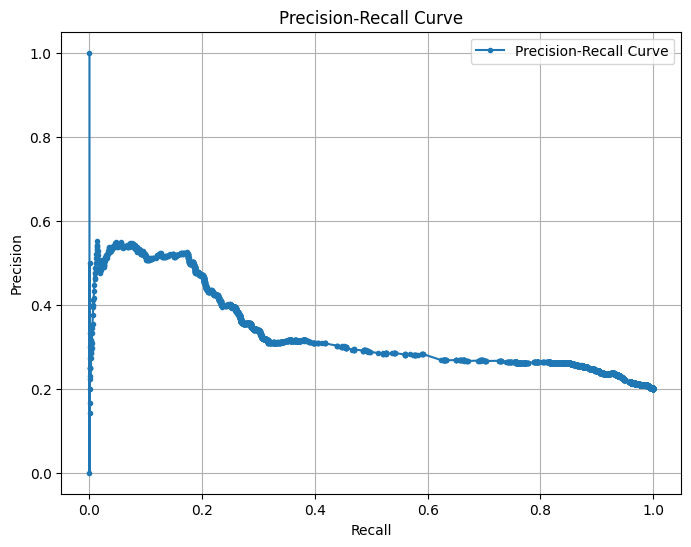

In [342]:

from sklearn.metrics import precision_recall_curve

def predict_proba(X, W, b):
    return sigmoid(X.matmul(W) + b)

# Generate predicted probabilities for test set
y_scores = predict_proba(torch.tensor(X_test, dtype=torch.float32), W, b)

# Compute precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Observations on the curve shape:
1. The model has very high precision at recall close to 0: This indicates the model is making very few positive predictions (most of which are accurate) and does not predict and lot of the actual positive values correctly. This results in a lot of false negatives but very few false positives. This is possibly due to the 20% positive class ratio in the test data

2. Precision drops rapidly as recall increases from 0: This means that expanding from the most confident predictions, the model is providing a lot of errors in its predictions with a lot of false positives and false negatives.  

3. As the recall increases, the precision slowly declines

Tradeoff value between precision and recall:  

precision = true positives / (true positives + false positives)  
recall = true positives / (true positives + false negatives)  

From the above graph, we can clearly observe the tradeoff between the precision and recall:  
1. High precision and low recall: This is the case when the model makes very few positive predictions, only when it is really confident. This region is preferred when false positives are costly and its okay if it misses a lot of true positives
2. High recall and low precision: As the recall moves from left to right, we can see that the precision steadily decreases. This is because the model becomes more confident in predicting positives and is able to cover most of the true positives, increasing the recall. However this reduces precision since the model also predicts a lot of false positives. This region is preferred when we want to capture as many positives there are in the test scenario at the expense of false positives.